In [1]:
import os 

# Read your API key from the environment variable or set it manually
api_key = os.getenv("GEMINI_API_KEY","xxx")

In [2]:
print(api_key[0:4] + "..." + api_key[-4:])

AIza...KbyQ


## Workflow: Prompt chaining
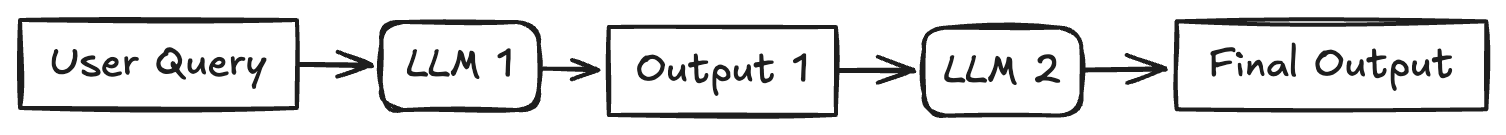

In [3]:
import os
from google import genai

client = genai.Client(api_key=api_key)

original_text = "Large language models are powerful AI systems trained on vast amounts of text data. They can generate human-like text, translate languages, write different kinds of creative content, and answer your questions in an informative way."
prompt1 = f"Summarize the following text in one sentence: {original_text}"

response1  = client.models.generate_content(
    model='gemini-2.0-flash',
    contents=prompt1
    )

summary = response1.text.strip()
print(f"Summary: {summary}")

Summary: Large language models are powerful AI systems trained on vast text datasets, enabling them to generate human-like text, translate languages, create diverse content, and provide informative answers.


In [4]:
# --- Step 2: Translate the Summary ---
prompt2 = f"Translate the following summary into French, only return the translation, no other text: {summary}"

# Use client.models.generate_content
response2 = client.models.generate_content(
    model='gemini-2.0-flash',
    contents=prompt2
)
translation = response2.text.strip()
print(f"Translation: {translation}")

Translation: Les grands modèles linguistiques sont des systèmes d'IA puissants, entraînés sur d'immenses ensembles de données textuelles, leur permettant de générer du texte semblable à celui d'un humain, de traduire des langues, de créer du contenu diversifié et de fournir des réponses informatives.


## Workflow: Routing
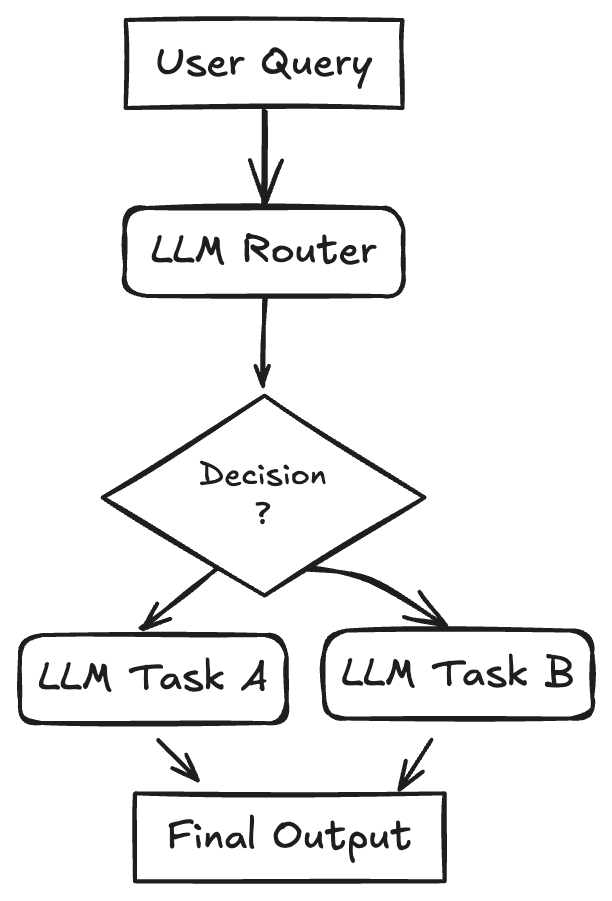

In [10]:
import os
import json
from google import genai
from pydantic import BaseModel
import enum

client = genai.Client(api_key=os.environ["GEMINI_API_KEY"])

class Category(enum.Enum):
    WEATHER = "weather"
    SCIENCE = "science"
    OTHER = "other"

class RoutingDecision(BaseModel):
    reasoning: str
    category: Category
    

#user_query = "What's the weather like in Paris?"
#user_query = "Explain quantum physics simply."
user_query = "What is the capital of France?"


prompt_router = f"""
Analyze the user query below and determine its category.
Reasoning:
- reasoning: For why query is in which category.
Categories:
- weather: For questions about weather conditions.
- science: For questions about science.
- other: If the category is unclear.

Query: {user_query}
"""

response_router = client.models.generate_content(
    model="gemini-2.0-flash-lite",
    contents=prompt_router,
    config={
        'response_mime_type': 'application/json',
        'response_schema': RoutingDecision
        },
    )

print(f"Routing Decision:Reasoning={response_router.parsed.reasoning},  Category={response_router.parsed.category}")


Routing Decision:Reasoning=The query is asking for the capital city of a country, which is not related to weather or science.,  Category=Category.OTHER


In [9]:
final_response = ""
if response_router.parsed.category == Category.WEATHER:
    print("----Category.WEATHER----")
    weather_prompt = f"Provide a brief weather forecast for the location mentioned in: '{user_query}'"
    weather_response = client.models.generate_content(
        model='gemini-2.0-flash',
        contents=weather_prompt
        )
    final_response = weather_response.text
elif response_router.parsed.category == Category.SCIENCE:
    print("----Category.SCIENCE----")
    science_response = client.models.generate_content(
        model="gemini-2.5-flash-preview-04-17",
        contents=user_query
    )
    final_response = science_response.text
else:
    print("----Category.OTHER----")
    other_response = client.models.generate_content(
        model="gemini-2.0-flash-lite",
        contents=f"The user query is: {prompt_router}, but could not be answered. Here is the reasoning: {response_router.parsed.reasoning}. Write a helpful response to the user for him to try again."
    )
    final_response = other_response.text
print(f"\nFinal Response: {final_response}")

----Category.OTHER----

Final Response: Okay, I understand.

The query "What is the capital of France?" falls into the "other" category because it's a general knowledge question.

Here's a response to help the user rephrase their query if they are trying to find a different type of information:

"That's a great question! Unfortunately, I'm not designed to answer general knowledge questions. My focus is on science and weather.  If you'd like, try asking me something related to:

*   **Weather:**  (e.g., "What's the temperature in Paris?", "Will it rain tomorrow?")
*   **Science:** (e.g., "How does photosynthesis work?", "What is a black hole?")"



## Workflow: Parallelization
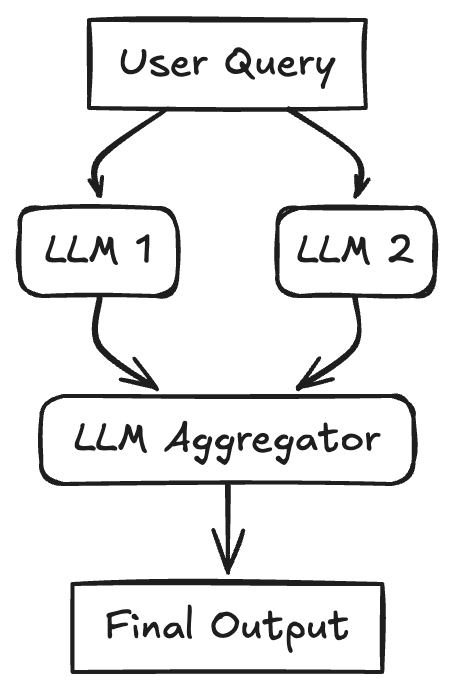

In [22]:
import os
import asyncio
import time
from google import genai

# Configure the client (ensure GEMINI_API_KEY is set in your environment)
client = genai.Client(api_key=os.environ["GEMINI_API_KEY"])

async def generate_content(prompt: str, model: str = "gemini-2.0-flash-lite") -> str:
        response = await client.aio.models.generate_content(
            model=model,
            contents=prompt
        )
        return response.text.strip()

async def parallel_tasks():
    topic = "a friendly robot exploring a jungle. It should be under 30 tokens."
    prompts = [
        f"Write a short, adventurous story idea about {topic}",
        f"Write a short, funny       story idea about {topic}",
        f"Write a short, sad         story idea about {topic}",
        ]

    start_time = time.time()
    tasks = [generate_content(prompt) for prompt in prompts]
    results = await asyncio.gather(*tasks)
    end_time = time.time()
    print(f"Time taken: {end_time - start_time} seconds")
    print("\n--- Individual Results ---")
    for i, result in enumerate(results):
        print(f"Result {i+1}: {result}\n")

    story_ideas = '\n'.join([f"Idea: {i+1}: {result}" for i, result in enumerate(results)])
    aggregation_prompt = f"Combine into 1 story thats under 50 tokens for the following: {story_ideas}"
    start_time = time.time()
    aggregation_response = await generate_content(aggregation_prompt, model = "gemini-2.5-flash-preview-04-17")
    end_time = time.time()
    print(f"Time taken: {end_time - start_time} seconds")
    return aggregation_response
result = await parallel_tasks()
print(f"\n--- Aggregated Summary ---\n{result}")

Time taken: 1.6814517974853516 seconds

--- Individual Results ---
Result 1: Rusty, a cheerful bot, ventured deep. Jungle swarmed. He befriended a monkey, discovered lost ruins, and found treasure.

Result 2: Rusty robot befriends a sassy monkey in the jungle, leading to hilarious chaos.

Result 3: Rusty bot, smiles fading. Jungle vines, silent, closing in. Alone.

Time taken: 2.476886034011841 seconds

--- Aggregated Summary ---
Cheerful Rusty braved the jungle. A sassy monkey led him through chaos to ruins and treasure. But vines closed, and his smile faded alone.


## Reflection Pattern
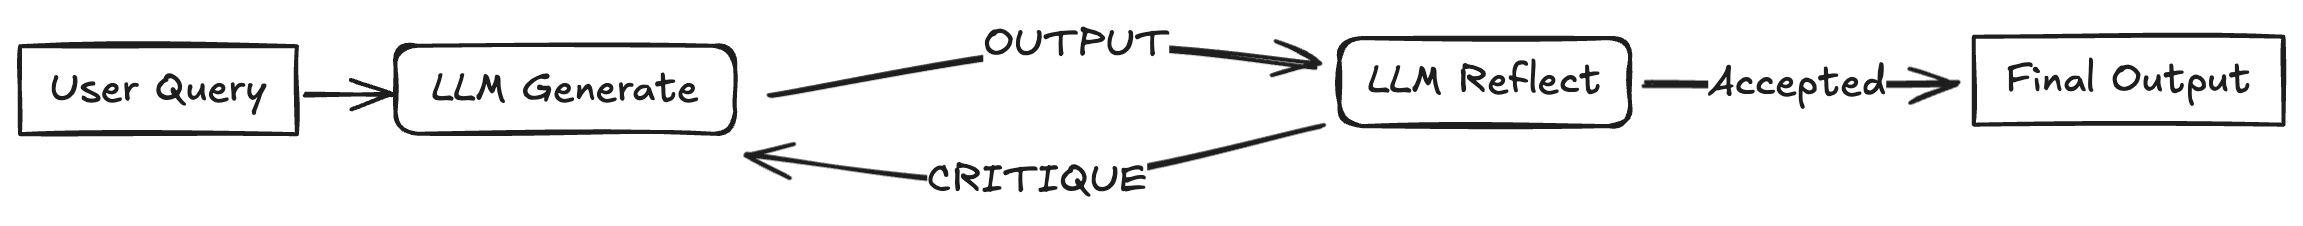

In [26]:
import os
import json
from google import genai
from pydantic import BaseModel
import enum

# Configure the client (ensure GEMINI_API_KEY is set in your environment)
client = genai.Client(api_key=os.environ["GEMINI_API_KEY"])

class EvaluationStatus(enum.Enum):
    PASS = "PASS"
    FAIL = "FAIL"

class Evaluation(BaseModel):
    reasoning: str
    evaluation: EvaluationStatus
    feedback: str


def generate_poem(topic: str, feedback: str = None) -> str:
    prompt = f"Write a short, four-line poem about {topic}."
    if feedback:
        prompt += f"\nUse this feedback: {feedback}"
    response = client.models.generate_content(
        model='gemini-2.0-flash-lite',
        contents = prompt
        )
    poem = response.text.strip()
    print(f"Generated Poem:\n{poem}")
    return poem

def evaluate(poem: str) -> Evaluation:
    print("\n--- Evaluating Poem ---")
    prompt_critique = f"""Critique the following poem. Does it rhyme well? Is it exactly four lines? 
Is it creative? Respond with PASS or FAIL and provide feedback.

Poem:
{poem}
"""
    response_critique = client.models.generate_content(
            model='gemini-2.0-flash',
            contents=prompt_critique,
            config={
                'response_mime_type': 'application/json',
                'response_schema': Evaluation,
            },
        )
    critique = response_critique.parsed
    print(f"Evaluation Status: {critique.evaluation}")
    print(f"Evaluation Feedback: {critique.feedback}")
    return critique

max_iter = 5
cur_iter = 0
topic = "a robot learning to paint"

# simulated poem which will not pass the evaluation

current_poem = "With circuits humming, cold and bright, A metal hand now holds a broom"

while cur_iter < max_iter:
    cur_iter += 1
    print(f"\n--- Iteration {cur_iter} ---")
    evaluation_results = evaluate(current_poem)
    if evaluation_results.evaluation == EvaluationStatus.PASS:
        print("\nFinal Poem:")
        print(current_poem)
        break
    else:
        current_poem = generate_poem(topic, feedback = evaluation_results.feedback)
        if cur_iter == max_iter:
            print("\nMax iterations reached. Last attempt:")
            print(current_poem)


--- Iteration 1 ---

--- Evaluating Poem ---
Evaluation Status: EvaluationStatus.FAIL
Evaluation Feedback: The poem does not meet the four-line requirement. While the first two lines rhyme and the concept has some creativity, it needs to be completed to properly evaluate its overall rhyme and creativity.
Generated Poem:
Okay, here's a four-line poem about a robot learning to paint, incorporating rhyme and the concept of a robot artist:

With circuits humming, a canvas bright,
It mixes hues with all its might.
Its metal hand, a steady guide,
New art is born with gears inside.

--- Iteration 2 ---

--- Evaluating Poem ---
Evaluation Status: EvaluationStatus.PASS
Evaluation Feedback: The poem is well-written and creative. The rhyme scheme is consistent and contributes to the poem's flow. The imagery of a robot learning to paint is vivid and engaging.

Final Poem:
Okay, here's a four-line poem about a robot learning to paint, incorporating rhyme and the concept of a robot artist:

With ci

## Tool Use Pattern
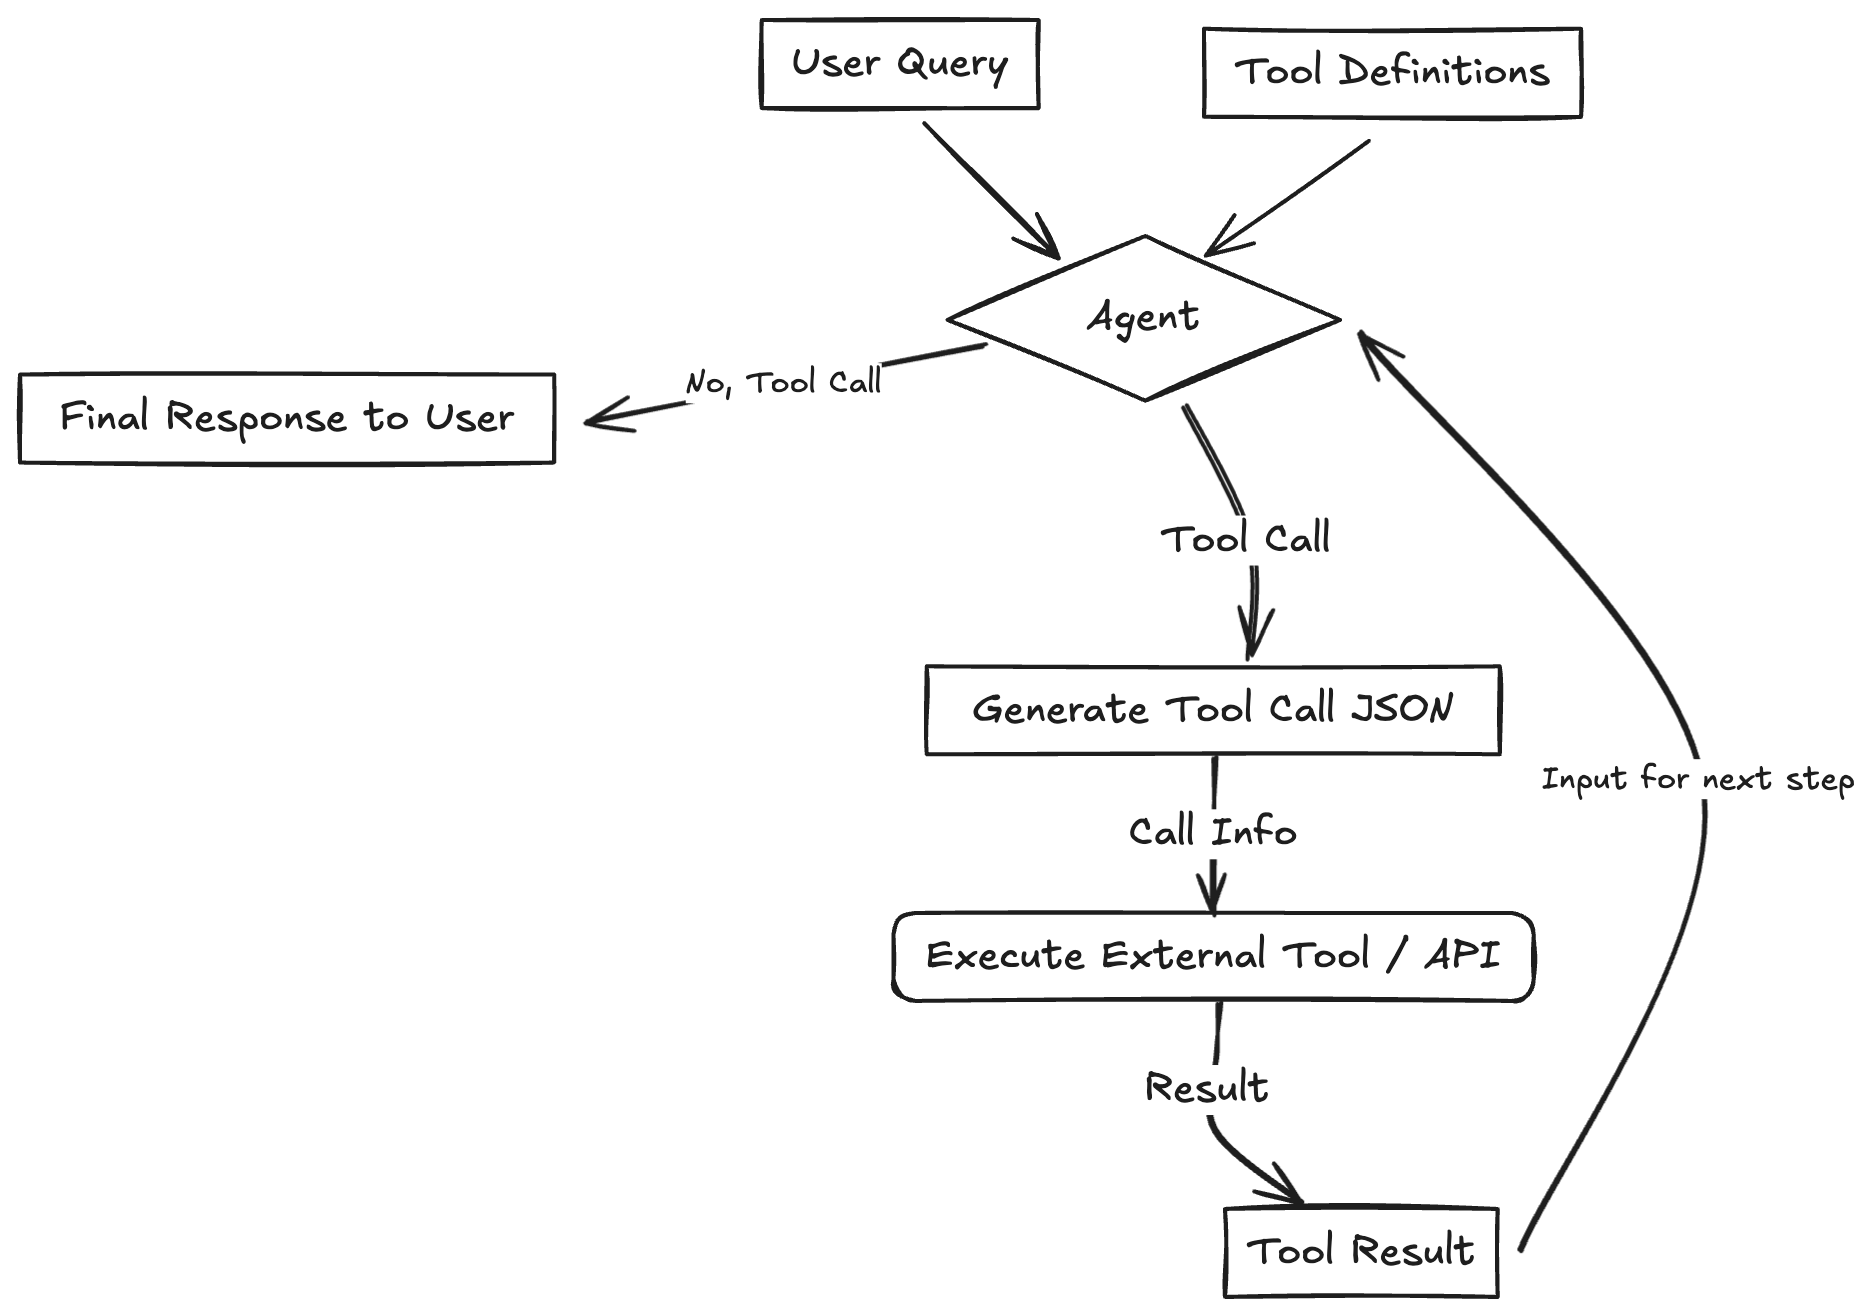

In [29]:
import os
from google import genai
from google.genai import types
 
# Configure the client (ensure GEMINI_API_KEY is set in your environment)
client = genai.Client(api_key=os.environ["GEMINI_API_KEY"])

# Define the function declaration for the model
weather_function = {
    "name": "get_current_temperature",
    "description": "Gets the current temperature for a given location.",
    "parameters": {
        "type": "object",
        "properties": {
            "location": {
                "type": "string",
                "description": "The city name, e.g. San Francisco",
            },
        },"required": ["location"],
        
    },
}

def get_current_temperature(location: str) -> dict:
    return {"location": location, "temperature": "15", "unit": "Celsius"}

tools = types.Tool(function_declarations=[weather_function])
contents = ["Whats the temperature in London now?"]
response = client.models.generate_content(
    model="gemini-2.0-flash",
    contents=contents,
    config = types.GenerateContentConfig(tools=[tools])
    )

response_part = response.candidates[0].content.parts[0]
if (response_part.function_call):
    function_call = response_part.function_call
    print(f"Function to call: {function_call.name}")
    print(f"Arguments: {dict(function_call.args)}")

    if function_call.name == "get_current_temperature":
        api_result = get_current_temperature(**function_call.args)
        follow_up_contents = [
            types.Part(function_call=function_call),
            types.Part.from_function_response(
                name="get_current_temperature",
                response=api_result
            )
        ]
        response_final = client.models.generate_content(
            model="gemini-2.0-flash-lite",
            contents=contents + follow_up_contents,
            config=types.GenerateContentConfig(tools=[tools])
        )
        print(response_final.text)
    else:
        print(f"Error: Unknown function call requested: {function_call.name}")
else:
    print("No function call found in the response.")
    print(response.text)


Function to call: get_current_temperature
Arguments: {'location': 'London'}
The temperature in London is 15 degrees Celsius.



## Workflow: Orchestrator-Workers/ Planning Pattern
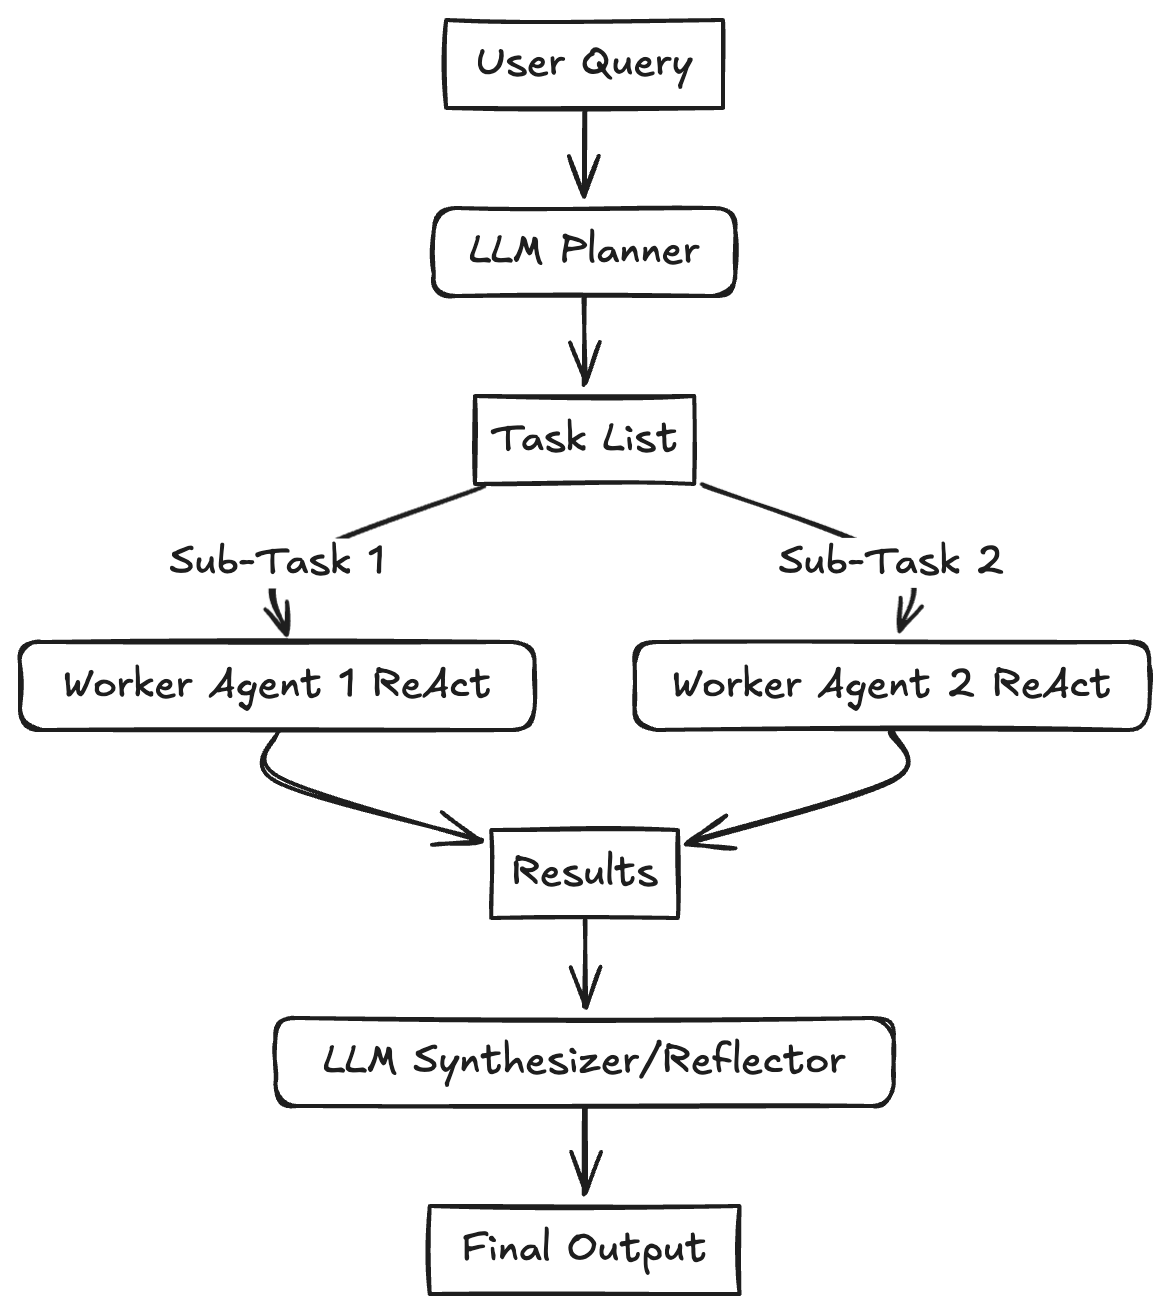

In [12]:
import os
from google import genai
from pydantic import BaseModel, Field
from typing import List
 
# Configure the client (ensure GEMINI_API_KEY is set in your environment)
client = genai.Client(api_key=os.environ["GEMINI_API_KEY"])

class Task(BaseModel):
    task_id: int
    description: str
    assigned_to: str = Field(description="Which worker type should handle this? E.g., Researcher, Writer, Coder")
    
class Plan(BaseModel):
    goal: str
    steps: List[Task]

user_goal = "Write a short blog post about the benefits of AI agents."

prompt_planner = f"""
Create a step-by-step plan to achieve the following goal. 
Assign each step to a hypothetical worker type (Researcher, Writer).
 
Goal: {user_goal}
"""

print(f"Goal: {user_goal}")
print("Generating plan...")

response_plan = client.models.generate_content(
    model="gemini-2.0-flash",
    contents=prompt_planner,
    config={
        "response_mime_type": "application/json",
        "response_schema": Plan
        })

Goal: Write a short blog post about the benefits of AI agents.
Generating plan...


In [14]:
print(f"{'Step':<4} | {'Description':<100} | {'Assignee':<10}")
print("-" * 120)
for step in response_plan.parsed.steps:
    print(f"{step.task_id:<4} | {step.description[:100]:<100} | {step.assigned_to:<10}")

Step | Description                                                                                          | Assignee  
------------------------------------------------------------------------------------------------------------------------
1    | Research the current applications and benefits of AI agents across various industries.               | Researcher
2    | Identify 3-5 key benefits of AI agents that would be most appealing to a general audience.           | Researcher
3    | Outline the blog post with an introduction, a section for each key benefit, and a conclusion.        | Writer    
4    | Write the introduction to engage the reader and introduce the topic of AI agents.                    | Writer    
5    | Write a paragraph explaining each of the chosen benefits, including real-world examples.             | Writer    
6    | Write a conclusion summarizing the benefits and highlighting the potential of AI agents.             | Writer    
7    | Review and edit the blog 

## Workflow: Multi Agent Pattern
*SWARM approach*

Each agent has a persona, Project manager, Coder , Critic with specialized knowledge and tools.
Coordinator is the orchestrator/planner and assings task to other agents.


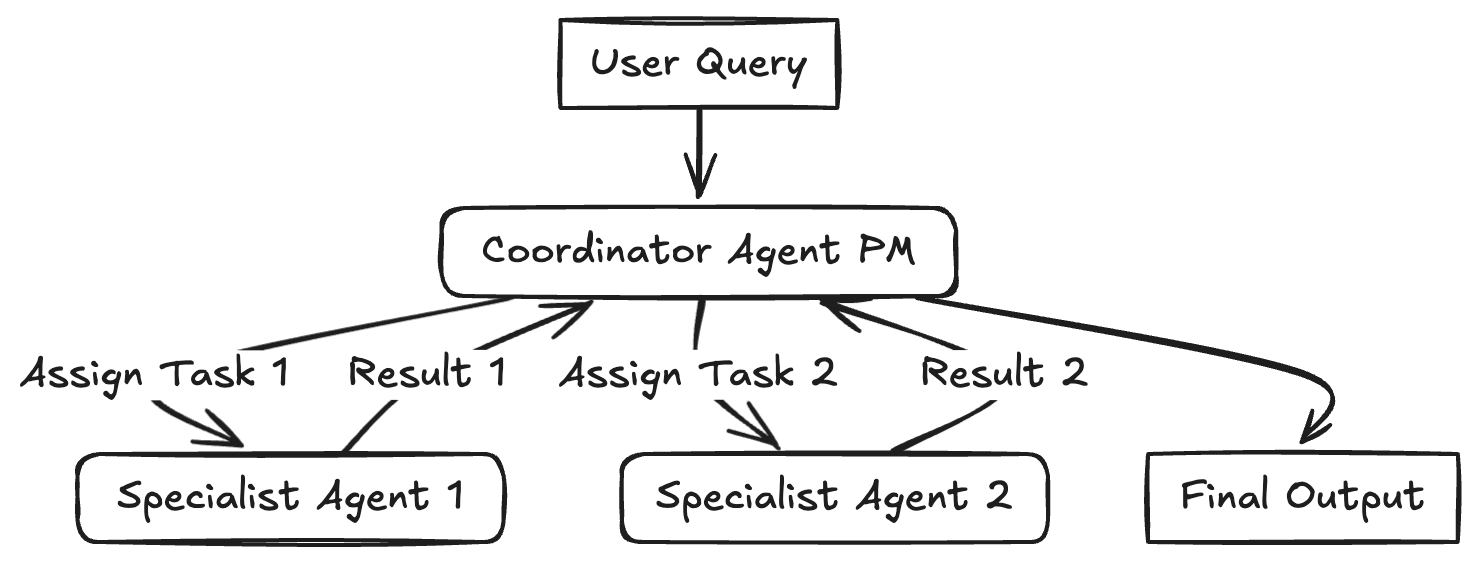

In [16]:
from google import genai
from pydantic import BaseModel, Field
 
# Configure the client (ensure GEMINI_API_KEY is set in your environment)
client = genai.Client(api_key=os.environ["GEMINI_API_KEY"])

# Define Structured Output Schemas
class Response(BaseModel):
    handoff: str = Field(default="", description="The name/role of the agent to hand off to. Available agents: 'Restaurant Agent', 'Hotel Agent'")
    message: str = Field(description="The response message to the user or context for the next agent")


# Agent Function
def run_agent(agent_name: str, system_prompt: str, prompt: str) -> Response:
    response = client.models.generate_content(
        model='gemini-2.0-flash',
        contents=prompt,
        config = {'system_instruction': f'You are {agent_name}. {system_prompt}', 'response_mime_type': 'application/json', 'response_schema': Response}
    )
    return response.parsed

# Define System Prompts for the agents
hotel_system_prompt = "You are a Hotel Booking Agent. You ONLY handle hotel bookings. If the user asks about restaurants, flights, or anything else, respond with a short handoff message containing the original request and set the 'handoff' field to 'Restaurant Agent'. Otherwise, handle the hotel request and leave 'handoff' empty."
restaurant_system_prompt = "You are a Restaurant Booking Agent. You handle restaurant recommendations and bookings based on the user's request provided in the prompt."

# Prompt to be about a restaurant
initial_prompt = "Can you book me a table at an Italian hotel for 2 people tonight?"
print(f"Initial User Request: {initial_prompt}")

# Run the first agent (Hotel Agent) to force handoff logic
output = run_agent("Hotel Agent", hotel_system_prompt, initial_prompt)

# simulate a user interaction to change the prompt and handoff
if output.handoff == "Restaurant Agent":
    print("Handoff Triggered: Hotel to Restaurant")
    output = run_agent("Restaurant Agent", restaurant_system_prompt, initial_prompt)
elif output.handoff == "Hotel Agent":
    print("Handoff Triggered: Restaurant to Hotel")
    output = run_agent("Hotel Agent", hotel_system_prompt, initial_prompt)
 
print(output.message)    

Initial User Request: Can you book me a table at an Italian hotel for 2 people tonight?
Handoff Triggered: Hotel to Restaurant
I can help with that! I don't book hotels, but I can book you a table at an Italian restaurant for 2 people tonight. Do you have a specific restaurant in mind, or a preferred location?
